[Update Aug 2020 Mengyan Zhang]

This notebook implements regression on the first round results with repeated kfold.

# Pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Repeated Kfold: (n_repeated: 10; n_split/kfold: 5)
    - Kernel: weighted degree kernel with shift
        - kernel normalisation: centering and unit norm
        - lmer: number of substring [3,4,5,6]
    - Gaussian process regression 
        - alpha: scalar value add to diagonal 
- Evaluation
   - metric: e.g. Mean square error; R2
   - true label: either sample or mean of sample. 

# Key Notes

## Splitting over sequences

The training and testing data should be split in terms of sequences rather than samples, since we hope to have good predictions on unseen data. Similar idea as shown in [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html).

## Training with multiple labels vs. sample mean?

We now training with multiple labels, i.e. repeated sequences inputs with different labels (replicates).
It worth thinking whether it is equivalent to use the sample mean directly.


## Evaluate on samples vs sample mean?

For evaluation (on both training and testing predictions), we evaluate using "samples" or "averages", indicating by "eva_on" parameter. 

## What matters

The recommendations at the end it what matters, so once we choose certain parameters, we should focus on how it changes our recommendations.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
kernel_dict = {
#     'Spectrum_Kernel': Spectrum_Kernel,
#     'Mixed_Spectrum_Kernel': Mixed_Spectrum_Kernel,
#     'WD_Kernel': WeightedDegree_Kernel,
#     'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel,
    'WD_Kernel_Shift': WD_Shift_Kernel
    
}

In [3]:
Path = '../../data/Results_Microplate_partialFalse_normTrue_roundRep_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,...,Rep5,Rep6,Rep7,Rep8,Rep9,AVERAGE,STD,Pred Mean,Pred Std,Pred UCB
0,0,RBS_1by1_0,reference,First_Plate,0,TTTAAGAAGGAGATATACAT,AGGAGA,2.433056,2.502155,2.315237,...,2.917124,2.275329,NaN,NaN,NaN,2.575968,0.313540,NaN,NaN,NaN
1,1,RBS_1by1_1,bps_noncore,First_Plate,0,CTTAAGAAGGAGATATACAT,AGGAGA,1.556251,1.654243,1.762146,...,2.312790,1.959275,NaN,NaN,NaN,1.839138,0.268820,NaN,NaN,NaN
2,2,RBS_1by1_2,bps_noncore,First_Plate,0,GTTAAGAAGGAGATATACAT,AGGAGA,0.603551,0.748674,0.921939,...,0.503846,0.711231,NaN,NaN,NaN,0.646754,0.188587,NaN,NaN,NaN
3,3,RBS_1by1_3,bps_noncore,First_Plate,0,ATTAAGAAGGAGATATACAT,AGGAGA,1.658359,1.874275,1.534988,...,1.747116,1.232548,NaN,NaN,NaN,1.598899,0.220191,NaN,NaN,NaN
4,4,RBS_1by1_4,bps_noncore,First_Plate,0,TCTAAGAAGGAGATATACAT,AGGAGA,1.545942,2.072095,1.386300,...,1.774833,2.146898,NaN,NaN,NaN,1.812638,0.300722,NaN,NaN,NaN
5,5,RBS_1by1_5,bps_noncore,First_Plate,0,TGTAAGAAGGAGATATACAT,AGGAGA,0.140540,0.113415,0.428642,...,0.201247,0.349550,NaN,NaN,NaN,0.219540,0.139196,NaN,NaN,NaN
6,6,RBS_1by1_6,bps_noncore,First_Plate,0,TATAAGAAGGAGATATACAT,AGGAGA,1.263922,1.295816,0.921114,...,1.225523,1.667016,NaN,NaN,NaN,1.203763,0.294206,NaN,NaN,NaN
7,7,RBS_1by1_8,bps_noncore,First_Plate,0,TTGAAGAAGGAGATATACAT,AGGAGA,1.506111,1.663509,NaN,...,1.795683,2.231638,NaN,NaN,NaN,1.841263,0.285769,NaN,NaN,NaN
8,8,RBS_1by1_9,bps_noncore,First_Plate,0,TTAAAGAAGGAGATATACAT,AGGAGA,0.457305,0.602012,1.358909,...,0.281771,0.446837,NaN,NaN,NaN,0.584317,0.394363,NaN,NaN,NaN
9,9,RBS_1by1_10,bps_noncore,First_Plate,0,TTTCAGAAGGAGATATACAT,AGGAGA,1.470120,0.929044,0.610260,...,1.210712,1.921650,NaN,NaN,NaN,1.276187,0.464689,NaN,NaN,NaN


In [4]:
#df = df[df['Group'] != 'bps'].reset_index()
df.shape

(266, 21)

(array([17., 45., 39., 39., 37., 52., 20.,  7.,  5.,  5.]),
 array([-1.71864371, -1.27497866, -0.8313136 , -0.38764855,  0.0560165 ,
         0.49968156,  0.94334661,  1.38701167,  1.83067672,  2.27434178,
         2.71800683]),
 <a list of 10 Patch objects>)

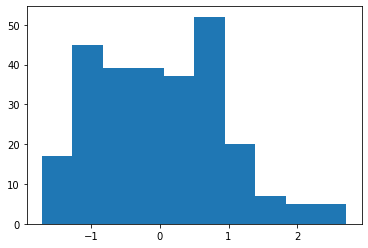

In [5]:
plt.hist(df['AVERAGE'])

# Repeated KFold 

In [6]:
kernel = 'WD_Kernel_Shift'
eva_metric = [mean_squared_error, r2_score]

gpr = GPR_Predictor(df, kernel_name = kernel)

In [7]:
# test para
# num_split = 5
# num_repeat = 2
# s_list = [0]
# # alpha_list = [0.5]
# alpha_list= [2]
# # alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
# l_list = [6] 
# sigma_0_list = [1,2]

In [8]:
num_split = 5
num_repeat = 5
s_list = [1]
# alpha_list = [0.5]
alpha_list= [1e-5, 1e-1, 1, 2, 5] 
# alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
l_list =[3,6]
# sigma_0_list = [0.5, 1, 1.5, 2, 2.5]
sigma_0_list = [1]
                                                                                                         
result_DataArray = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                      l_list = l_list, s_list = s_list, sigma_0_list = sigma_0_list)

Repeated KFold Running ...


IntProgress(value=0, max=250)

init kernel
1
init kernel
2
init kernel
3
init kernel
4
init kernel
5
init kernel
6
init kernel
7
init kernel
8
init kernel
9
init kernel
10
init kernel
11
init kernel
12
init kernel
13
init kernel
14
init kernel
15
init kernel
16
init kernel
17
init kernel
18
init kernel
19
init kernel
20
init kernel
21
init kernel
22
init kernel
23
init kernel
24
init kernel
25
init kernel
26
init kernel
27
init kernel
28
init kernel
29
init kernel
30
init kernel
31
init kernel
32
init kernel
33
init kernel
34
init kernel
35
init kernel
36
init kernel
37
init kernel
38
init kernel
39
init kernel
40
init kernel
41
init kernel
42
init kernel
43
init kernel
44
init kernel
45
init kernel
46
init kernel
47
init kernel
48
init kernel
49
init kernel
50
init kernel
51
init kernel
52
init kernel
53
init kernel
54
init kernel
55
init kernel
56
init kernel
57
init kernel
58
init kernel
59
init kernel
60
init kernel
61
init kernel
62
init kernel
63
init kernel
64
init kernel
65
init kernel
66
init kernel
67
init

In [9]:
import pickle

with open('repeated_kfold_wd_shift_round01.pickle', 'wb') as handle:
    pickle.dump(result_DataArray, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('repeated_kfold_wd_shift_round01.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [10]:
result_pkl.loc[dict(train_test = 'Test')]

<xarray.DataArray (eva_on: 2, eva_metric: 2, alpha: 5, l: 2, s: 1, sigma_0: 1, num_repeat: 5, num_split: 5)>
array([[[[[[[[ 1.03567649e+00,  7.96198549e-01,  9.70839162e-01,
               1.07753295e+00,  1.42803616e+00],
             [ 9.58059928e-01,  8.75782742e-01,  1.17958111e+00,
               8.25490352e-01,  1.04049654e+00],
             [ 1.06537690e+00,  9.95308295e-01,  1.02921479e+00,
               9.53005711e-01,  1.06095288e+00],
             [ 1.06530192e+00,  1.26024971e+00,  1.49331575e+00,
               8.90401989e-01,  9.00652843e-01],
             [ 1.20114755e+00,  1.07154745e+00,  1.06327634e+00,
               9.92271800e-01,  1.24885133e+00]]]],



          [[[[ 1.17483836e+00,  9.10846883e-01,  8.25076310e-01,
               1.19069957e+00,  1.08603668e+00],
             [ 1.04274669e+00,  1.04709732e+00,  7.92927371e-01,
               9.48549636e-01,  1.47722081e+00],
             [ 1.02445569e+00,  8.52328386e-01,  7.48469405e-01,
               1.35526445e+00,  1.28671246e+00],
             [ 1.27253592e+00,  8.36408197e-01,  9.57513759e-01,
...
               2.58292515e-01,  1.60588943e-01],
             [ 3.15626630e-01,  2.80498835e-01,  8.59813705e-02,
               1.61379201e-01, -6.57463513e-02],
             [ 1.23969034e-01,  3.36917903e-02,  1.77741653e-01,
               3.43529133e-01,  3.43772589e-01],
             [ 3.01176569e-02, -2.08622559e-02,  3.32033596e-01,
               2.77190923e-01,  1.54170486e-01]]]],



          [[[[ 2.42903192e-01,  2.95656294e-01,  1.26333243e-01,
               1.97634604e-01,  2.79859147e-01],
             [ 3.20930309e-01,  2.25907029e-01,  6.65915389e-02,
               7.31170878e-02,  2.98384828e-01],
             [ 3.18282728e-01,  2.70122387e-01,  3.69157456e-01,
              -1.49774734e-01, -8.23771650e-02],
             [ 1.03499214e-02,  1.96753048e-01,  1.84499930e-01,
               1.21495044e-01,  2.90027541e-01],
             [ 1.89794588e-01,  4.53121448e-01,  2.89475463e-01,
               2.23211465e-01, -1.23586526e-01]]]]]]]])
Coordinates:
    train_test  <U5 'Test'
  * eva_on      (eva_on) <U7 'samples' 'seq'
  * eva_metric  (eva_metric) object <function mean_squared_error at 0x7fa9d2d...
  * alpha       (alpha) float64 1e-05 0.1 1.0 2.0 5.0
  * l           (l) int64 3 6
  * s           (s) int64 1
  * sigma_0     (sigma_0) int64 1
  * num_repeat  (num_repeat) int64 0 1 2 3 4
  * num_split   (num_split) int64 0 1 2 3 4

In [11]:
result_pkl[1].mean(axis = -1).mean(axis = -1)

<xarray.DataArray (eva_on: 2, eva_metric: 2, alpha: 5, l: 2, s: 1, sigma_0: 1)>
array([[[[[[ 1.05914277]],

          [[ 1.06615648]]],


         [[[ 1.07644976]],

          [[ 1.06233278]]],


         [[[ 0.93630933]],

          [[ 0.90231503]]],


         [[[ 0.87454774]],

          [[ 0.85555483]]],


...


         [[[-0.1410328 ]],

          [[-0.12018787]]],


         [[[ 0.04577304]],

          [[ 0.08066379]]],


         [[[ 0.10671842]],

          [[ 0.13436817]]],


         [[[ 0.16314931]],

          [[ 0.18751479]]]]]])
Coordinates:
    train_test  <U5 'Test'
  * eva_on      (eva_on) <U7 'samples' 'seq'
  * eva_metric  (eva_metric) object <function mean_squared_error at 0x7fa9d2d...
  * alpha       (alpha) float64 1e-05 0.1 1.0 2.0 5.0
  * l           (l) int64 3 6
  * s           (s) int64 1
  * sigma_0     (sigma_0) int64 1

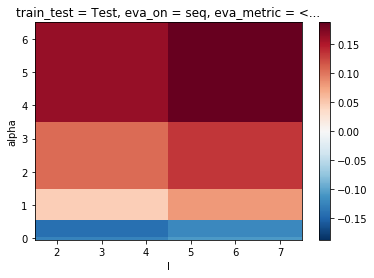

In [12]:
result_pkl[1][1][1].mean(axis = -1).mean(axis = -1).plot()